In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import sys
import numpy
import pandas as pd
import tensorflow as tf
from keras import layers
import keras


#taking the model
#from VAE_model_extended_moreDKL import *
from VAE_testDK_Reco_Loss import *
import matplotlib.pyplot as plt

import ROOT

2022-08-03 15:07:02.495209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 15:07:02.495265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Welcome to JupyROOT 6.26/04


In [2]:
ROOT.ROOT.EnableImplicitMT()
#RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

In [3]:
DEBUGGING_MODE = True

def pdf_summary(pdf, debugging_mode=DEBUGGING_MODE):
    print(f"Pandas DataFrame shape is: {pdf.shape}")
    if debugging_mode:
        return pdf.head(1)

### variable from the nutple

In [4]:
#pd_variables = ['deltaetajj', 'deltaphijj', 'etaj1', 'etaj2', 'etal1', 'etal2',
#       'met', 'mjj', 'mll',  'ptj1', 'ptj2', 'ptl1',
#       'ptl2', 'ptll']#,'phij1', 'phij2', 'w']
#kinematicFilter = "ptj1 > 30 && ptj2 >30 && deltaetajj>2 && mjj>200"
kinematicFilter = "ptj1 > 30 && abs(etaj1-etaj2) > 2. && ptj2 >30 && mjj>200"
ntuple_location = "../../ntuples4Momentum/"

In [5]:
dfSM = ROOT.RDataFrame("SSWW_SM",ntuple_location+"ntuple_SSWW_SM.root")
dfSM = dfSM.Filter(kinematicFilter)
dfBSM = ROOT.RDataFrame("SSWW_cW_QU",ntuple_location+"ntuple_SSWW_cW_QU.root")
dfBSM = dfBSM.Filter(kinematicFilter)
np_SM = dfSM.AsNumpy()
wSM = dfSM.AsNumpy(["w"])
npd = pd.DataFrame.from_dict(np_SM)
wpdSM = pd.DataFrame.from_dict(wSM)
# Take all columns og dfBSM because of using RDateFrame.AsNumpy() without any filter
np_BSM = dfBSM.AsNumpy()
wBSM = dfBSM.AsNumpy(["w"])
npd_BSM = pd.DataFrame.from_dict(np_BSM)
wpdBSM = pd.DataFrame.from_dict(wBSM)

In [6]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

npd = clean_dataset(npd) 
wpdSM = clean_dataset(wpdSM)
npd_BSM = clean_dataset(npd_BSM)
wpdBSM = clean_dataset(wpdBSM)

In [7]:
npd.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,303.458801,701.662598,66.335213,61.839161,-1.531009,1.705899,-1.010756,0.059856,115.725586,914.647095,...,37.129974,-46.985771,18.432892,-183.381699,20.959143,40.034378,-276.328735,656.85614,-50.817711,3.697025


In [8]:
npd_BSM.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)

In [9]:
nEntries = 3000000
npd = npd.head(nEntries)
npd_BSM = npd_BSM.head(nEntries)
wpdSM = wpdSM.head(nEntries)
wpdBSM = wpdBSM.head(nEntries)

In [10]:
# #to be done for all the pt and mass and met variables
for var in ['met', 'mjj', 'mll', 'ptj1', 'ptj2', 'ptl1',
            'ptl2', 'ptll',"Ej1","Ej2","El1","El2"]:
   npd[var] = np.log10(npd[var])
   npd_BSM[var] = np.log10(npd_BSM[var])
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,2.4821,2.846128,1.821744,1.791264,-1.531009,1.705899,-1.010756,0.059856,2.063429,2.961254,...,37.129974,-46.985771,18.432892,-183.381699,20.959143,40.034378,-276.328735,656.85614,-50.817711,3.697025


### Combining SM and BSM data

In [11]:
Y_true_SM = np.full(npd.shape[0],0)
Y_true_BSM = np.full(npd_BSM.shape[0],1)
labels_arr = np.concatenate((Y_true_SM,Y_true_BSM))

In [12]:
samples_df = pd.concat([npd,npd_BSM])
samples_df['labels'] = labels_arr
samples_df = samples_df.sample(frac=1)
pdf_summary(samples_df)

Pandas DataFrame shape is: (1550423, 29)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,labels
650276,2.055217,3.036463,2.190459,2.77012,1.718473,-1.925987,-1.528222,1.989756,1.982968,2.840309,...,-156.69278,38.022858,-50.719723,35.578259,21.141064,106.48085,-1042.349121,-141.109909,567.388123,1


In [13]:
shuffled_labels_df = samples_df['labels']
shuffled_samples_df = samples_df.drop(['labels'], axis='columns')

In [14]:
X_train, X_rem, y_train, y_rem = train_test_split(shuffled_samples_df,
                                                  shuffled_labels_df,
                                                  train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,
                                                    y_rem, 
                                                    test_size=0.5)
SM_train,SM_test,_,_ = train_test_split(npd, npd, test_size=0.2, random_state=1)
BSM_train,BSM_test,_,_ = train_test_split(npd_BSM, npd_BSM, test_size=0.2, random_state=1)
#wx_train, wx_test, wy_train, wy_test = train_test_split(wpdSM, wpdSM, test_size=0.2, random_state=1)

BSM_train, BSM_test, y_BSM_train, y_BSM_test = train_test_split(npd_BSM, Y_true_BSM, test_size=0.2, random_state=1)
#wBSM_train, wBSM_test, _ , _ = train_test_split(wpdBSM, wpdBSM, test_size=0.2, random_state=1)
#print wx_train,X_train
#wx = wx_train["w"].to_numpy()
#wxtest = wx_test["w"].to_numpy()
#wBSM = wBSM_train["w"].to_numpy()
#wBSMtest = wBSM_test["w"].to_numpy()

### scale data

In [15]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(shuffled_samples_df)
scaled_x_train = scaler.transform(X_train)
scaled_x_valid = scaler.transform(X_valid)
scaled_x_test = scaler.transform(X_test)
BSM_test = scaler.transform(BSM_test)

In [16]:
n_inputs = npd.shape[1]
original_dim = n_inputs

intermediate_dim = 50 #50 by default
input_dim = 10 #was 20 in default
half_input = 7 #was 20 in the newTest
latent_dim = 10 #tried 7 as well  #was 3 for optimal performance
epochs = 20 #806
batch_size=64 #32
nameExtenstion = str(intermediate_dim) + "_" +\
                 str(input_dim) + "_" +\
                 str(half_input) + "_" +\
                 str(latent_dim) + "_" +\
                 str(epochs) + "_" +\
                 str(batch_size)


In [17]:
vae = VariationalAutoEncoder(
                             original_dim, 
                             intermediate_dim, 
                             input_dim, 
                             half_input, 
                             latent_dim,
                             ) 

2022-08-03 15:07:32.760137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-03 15:07:32.760196: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-03 15:07:32.760253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2022-08-03 15:07:32.760804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  
#               loss=tf.keras.losses.MeanSquaredError()
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               run_eagerly=True, loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
#               loss_weights=[0.1],loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
vae.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss="binary_crossentropy",
                metrics = [tf.keras.metrics.BinaryAccuracy()]
            )
vae_hist = vae.fit(
                    scaled_x_train,
                    y_train,
                    validation_data=(scaled_x_valid, y_valid), 
                    epochs=epochs, 
                    batch_size = batch_size
                ) 

Epoch 1/20
19381/19381 [==============================] - 151s 8ms/step - loss: 0.4102 - binary_accuracy: 0.8529 - val_loss: 0.3822 - val_binary_accuracy: 0.8650
Epoch 2/20
19381/19381 [==============================] - 140s 7ms/step - loss: 0.3850 - binary_accuracy: 0.8639 - val_loss: 0.3815 - val_binary_accuracy: 0.8652
Epoch 3/20
19381/19381 [==============================] - 140s 7ms/step - loss: 0.3845 - binary_accuracy: 0.8642 - val_loss: 0.3799 - val_binary_accuracy: 0.8656
Epoch 4/20
19381/19381 [==============================] - 138s 7ms/step - loss: 0.3845 - binary_accuracy: 0.8644 - val_loss: 0.3819 - val_binary_accuracy: 0.8647
Epoch 5/20
19381/19381 [==============================] - 147s 8ms/step - loss: 0.3841 - binary_accuracy: 0.8642 - val_loss: 0.3800 - val_binary_accuracy: 0.8654
Epoch 6/20
19381/19381 [==============================] - 154s 8ms/step - loss: 0.3839 - binary_accuracy: 0.8643 - val_loss: 0.3802 - val_binary_accuracy: 0.8655
Epoch 7/20
19381/19381 [====

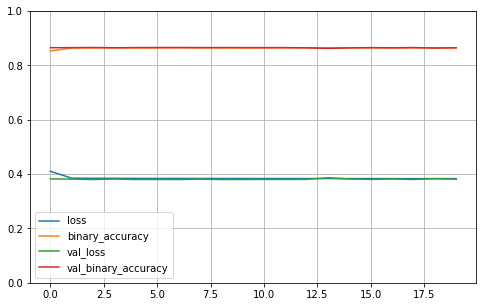

In [19]:
pd.DataFrame(vae_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [20]:
vae.evaluate(X_test, y_test)

4846/4846 [==============================] - 18s 4ms/step - loss: 10205477813016854528.0000 - binary_accuracy: 0.4219


[1.0205477813016855e+19, 0.4218958616256714]

In [21]:
encoderDecoder =  EncoderDecoder(original_dim,
                                 intermediate_dim,
                                 input_dim,
                                 half_input,
                                 latent_dim)
reco = encoderDecoder.predict(scaled_x_test)

4846/4846 [==============================] - 12s 2ms/step


In [22]:
# keras.models.save_model(encoderDecoder,'encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
# keras.models.save_model(vae,'vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
#numpy.savetxt("lossVAE_test_newModelDimenstions_MinMaxScaler_"+nameExtenstion+".csv",hist.history["loss"],delimiter=",")
#vae=tf.keras.models.load_model('vae_test_newModelUsingLatentSpace_'+nameExtenstion)

In [23]:
output_SM = vae.predict(SM_test)
output_BSM = vae.predict(BSM_test)

4091/4091 [==============================] - 12s 3ms/step


In [24]:
np.count_nonzero(np.isnan(output_SM))

0

In [25]:
np.count_nonzero(np.isnan(output_BSM))

0

In [26]:
# print(vae_hist.history)

In [34]:
output =  np.concatenate((output_SM,output_BSM))
new_output = output[:285936]
label_test = np.concatenate((y_test,y_BSM_test))

In [28]:
# label_test.isnull().values.any()
# numpy.isnan(output).any()
# np.dropna(output)
# output = output[~numpy.isnan(output)]

In [35]:
# output =  np.concatenate((output_SM,output_BSM))
# output = output[~numpy.isnan(output)]
# label_test = np.concatenate((y_test,y_BSM_test))
new_output = output[:285936]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(label_test,new_output)
print('roc_auc_score for VAE_cW_QU: ', roc_auc_score(label_test,new_output))

roc_auc_score for VAE_cW_QU:  0.2281195079086116


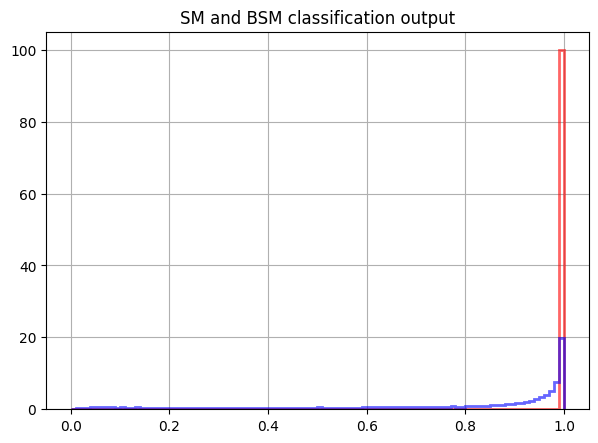

In [36]:
bins=100
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.hist(output_SM,
        bins=bins, 
        density=1,
        range=[0.,1.],
        histtype="step",
        color="red",
        alpha=0.6,
        linewidth=2,
        label="SM Output"
        )                        
ax.hist(output_BSM,
        bins=bins, 
        density=1,
        range=[0.,1.],
        histtype="step",
        color="blue",
        alpha=0.6,
        linewidth=2,
        label="BSM Output"
        )                         
plt.rc('legend',fontsize='small')    
plt.title("SM and BSM classification output") 
plt.show()

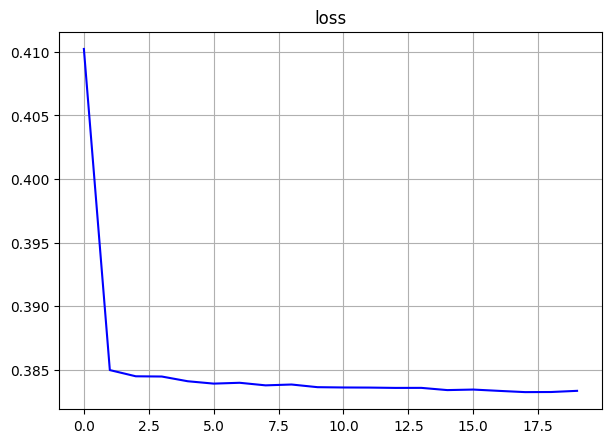

In [37]:
x_bins = range(len(vae_hist.history["loss"]))
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.plot(x_bins,vae_hist.history["loss"],color="blue",label="training losss")                        
plt.rc('legend',fontsize='small') 
plt.title("loss")    
plt.show()

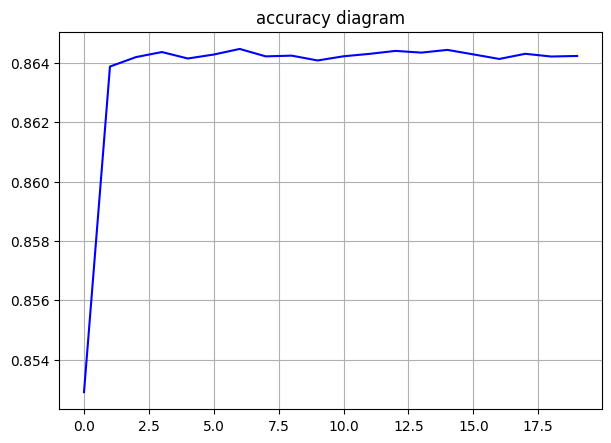

In [38]:
x_bins = range(len(vae_hist.history["binary_accuracy"]))
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.plot(x_bins,vae_hist.history["binary_accuracy"],color="blue",label="binary accuracy")                        
plt.rc('legend',fontsize='small')   
plt.title("accuracy diagram") 
plt.show()

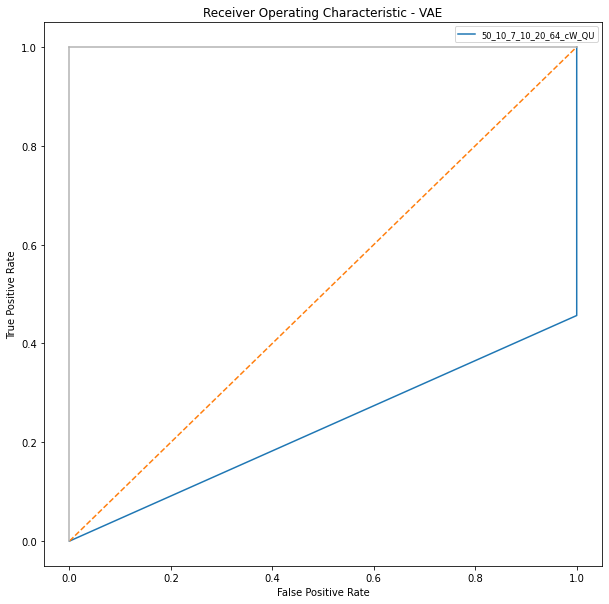

In [39]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - VAE')
plt.plot(false_positive_rate1, true_positive_rate1,label=nameExtenstion+"_cW_QU")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()